For this project, I'll be focusing on question 1: 

We would like to know which "kinds" of players are most likely to contribute a large amount of data so that we can target those players in our recruiting efforts.

I’ll examine whether total played hours can predict a player’s experience level, providing insight into which experience levels are likely to contribute a large amount of data, measured by playing time.

The question is: Can playing time predict a Minecraft player’s experience level?

Two files are available. In players.csv, there are 10 variables:
- experience: Player experience level, categorized into Beginner, Amateur, Pro, Veteran.
- subscribe: Whether the player has subscribed to the email system (categorical).
- hashedEmail: Hashed player email for privacy.
- played_hours: Total playing time in hours (numerical).
- name: Altered player name for privacy.
- gender: Player’s gender (categorical).
- age: Player’s age (numerical).
- individualId: Assigned player ID, removed for privacy.
- organizationName: Player’s organization, removed for privacy.

In sessions.csv, there are 5 variables:
- hashedEmail: Same as above.
- start_time, end_time: Session times, each containing multiple variables needing tidying if used (numerical).
- original_start_time, original_end_time: Start/end times in UNIX timestamp format (starts January 1, 1970 UTC). Numerical.

I will use the players.csv file as it includes the critical variables for this analysis (played_hours and experience) and focuses on total playing time rather than specific session times. To address this, I will use KNN classification to predict player experience based on total playing time. I will convert the experience, subscribe, and gender variables into factors using as_factor() and remove the hashedEmail, name, individualId, and organizationName columns with select() since they are only for identification and irrelevant to the data analysis.

I’ll use players.csv, as it includes the critical variables (played_hours and experience) and focuses on total playing time rather than session times. To address this, I’ll use KNN classification to predict player experience based on total playing time. I’ll convert the experience and gender variables into factors using as_factor(), and remove hashedEmail, name, individualId, and organizationName columns with select() as they are only for identification and irrelevant to analysis.

KNN classification suits this project as I'm predicting a class (experience) and working with a smaller dataset (around 200 observations), so performance won’t be an issue. I'll assume other variables, such as gender, age, and subscribe, have minimal effect on playing time, and plotting age against playing time showed no relationship so I'll infer that it has little effect as well.

KNN is simple and intuitive, providing high accuracy, though it can be slower with larger datasets. However, I'm using a small dataset, so this won’t be a concern. It can also be less effective with multiple predictors; this is also not an issue because I'm only using one predictor.

For preprocessing, I’ll use 5-fold cross-validation with a 60-40 training/testing split and use experience as the strata. Cross-validation reduces the impact of random variance in testing. I’ll split the dataset before model training to avoid skewing results, using initial_split(), training(), and testing() for splitting, and vfold_cv() for cross-validation. Setting the seed at the start with set.seed() ensures reproducibility of randomness.



In [1]:
library(tidyverse)
library(repr)
library(dplyr)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [2]:
url <- 'https://drive.google.com/uc?export=download&id=1Mw9vW0hjTJwRWx0bDXiSpYsO3gKogaPz'
players <- read_csv(url) |>
    select(-hashedEmail, -name, -individualId, -organizationName) |>
    mutate(experience = as_factor(experience), gender = as_factor(gender), subscribe = as_factor(subscribe))
    
players

Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,played_hours,gender,age
<fct>,<fct>,<dbl>,<fct>,<dbl>
Pro,TRUE,30.3,Male,9
Veteran,TRUE,3.8,Male,17
Veteran,FALSE,0.0,Male,17
Amateur,TRUE,0.7,Female,21
Regular,TRUE,0.1,Male,21
Amateur,TRUE,0.0,Female,17
Regular,TRUE,0.0,Female,19
Amateur,FALSE,0.0,Male,21
Amateur,TRUE,0.1,Male,17


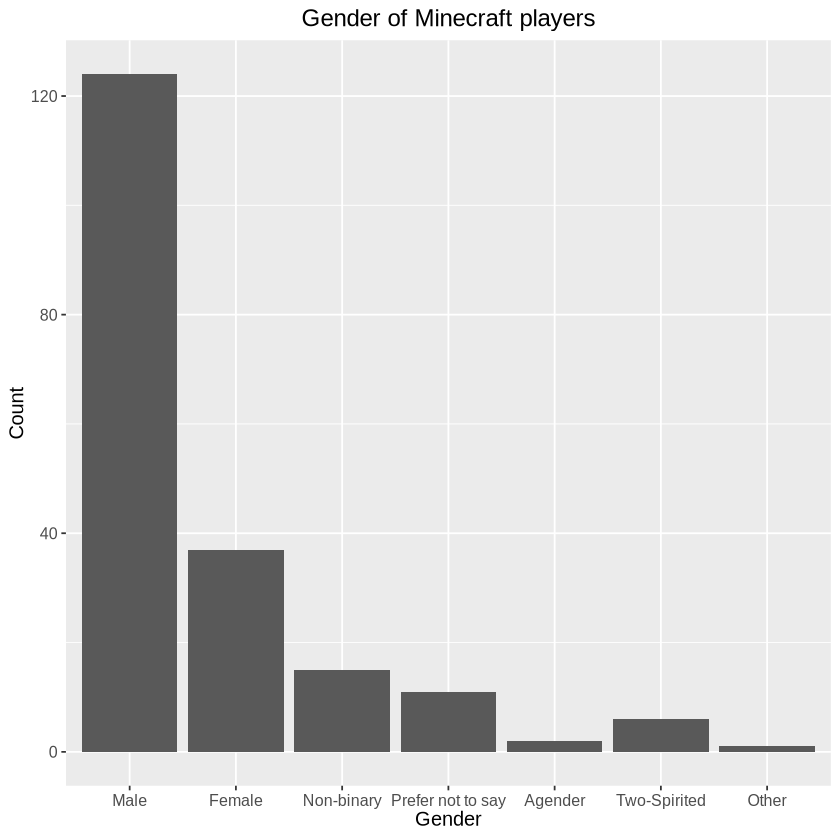

In [3]:
options(repr.plot.width = 7, repr.plot.height = 7)

players_gender_bar <- ggplot(players, aes(x = gender)) +
    geom_bar() +
    labs(x = "Gender", y = "Count", title = "Gender of Minecraft players") +
    theme(text = element_text(size = 12), plot.title = element_text(hjust = 0.5)) 
    
players_gender_bar

Players in this study are mostly male, whith female being the 2nd highest gender in terms of number.  

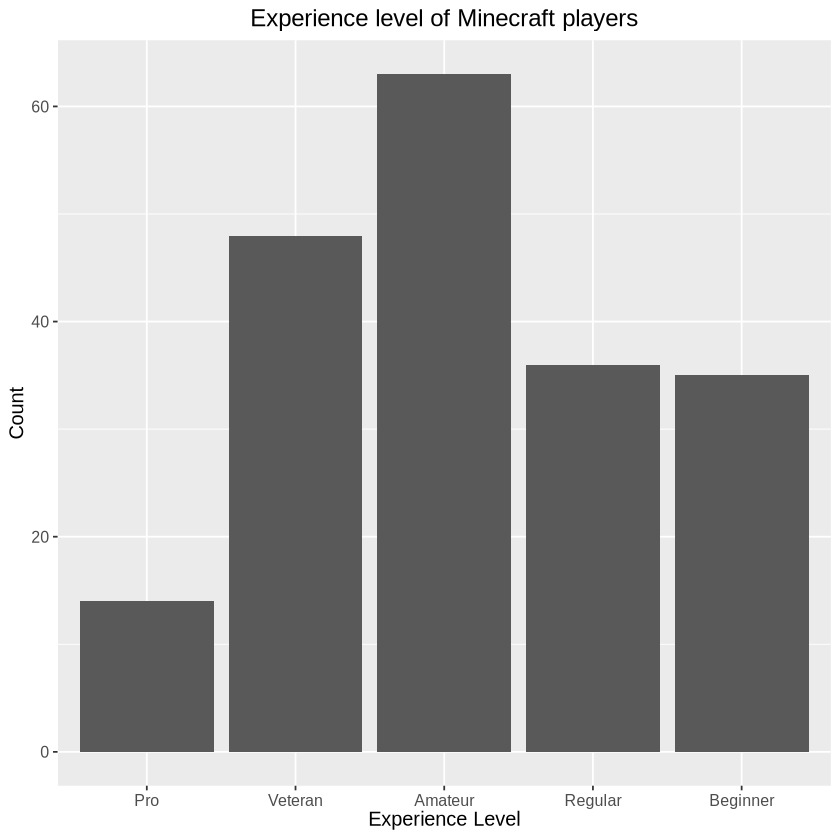

In [4]:
players_experience_bar <- ggplot(players, aes(x = experience)) +
    geom_bar() +
    labs(x = "Experience Level", y = "Count", title = "Experience level of Minecraft players") +
    theme(text = element_text(size = 12), plot.title = element_text(hjust = 0.5))

players_experience_bar

Most players are amateur, with veteran, regular, and beginner trailing behind. There are not many pro players

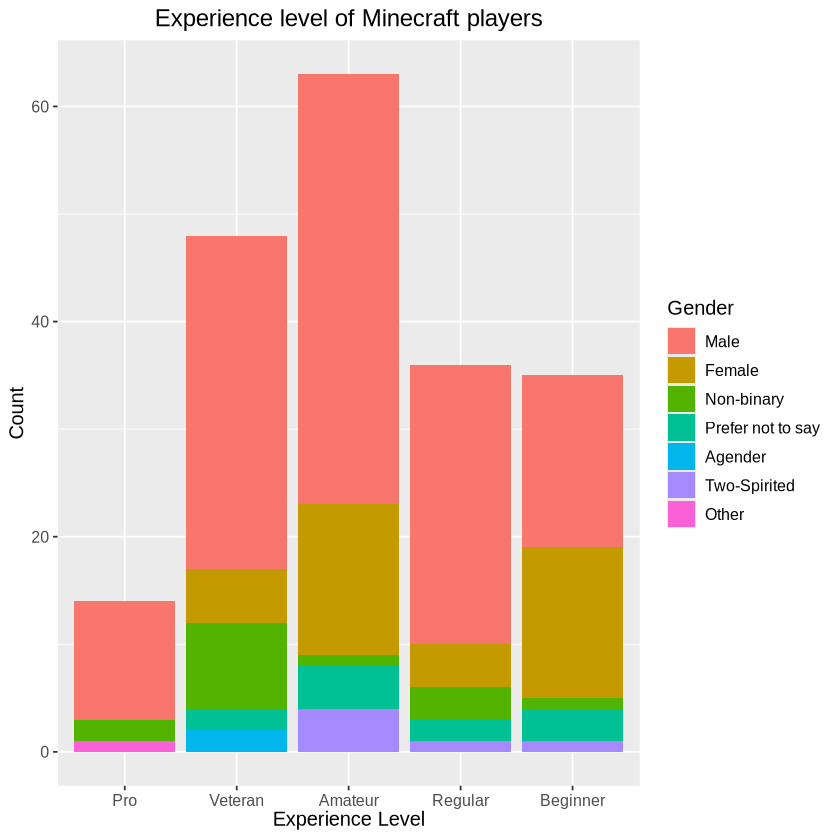

In [5]:
players_experience_bar_gender <- ggplot(players, aes(x = experience, fill = gender)) +
    geom_bar() +
    labs(x = "Experience Level", y = "Count", title = "Experience level of Minecraft players", fill = "Gender") +
    theme(text = element_text(size = 12), plot.title = element_text(hjust = 0.5))

players_experience_bar_gender

The distribution of gender across all experience levels are relatively the same, with pro differing slightly.

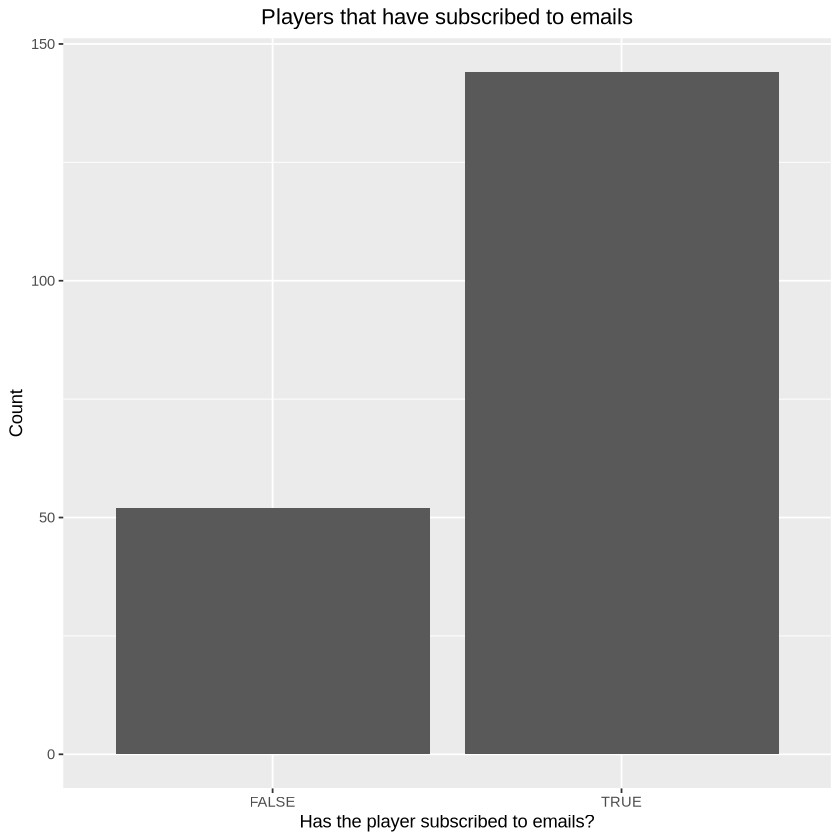

In [6]:
players_subscribe_bar <- ggplot(players, aes(x = subscribe)) +
    geom_bar() +
    labs(x = "Has the player subscribed to emails?", y = "Count", title = "Players that have subscribed to emails") +
    theme(plot.title = element_text(hjust = 0.5))
    
players_subscribe_bar

A greater proportion of players are subscribed to emails.

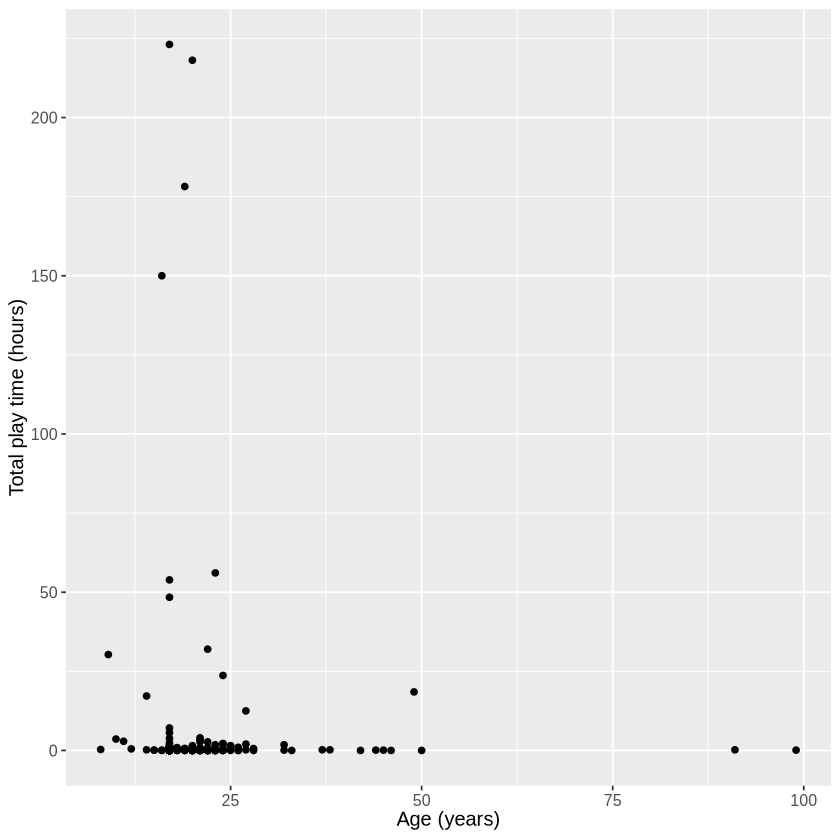

In [7]:
age_vs_time <- ggplot(players, aes(x = age, y = played_hours)) +
    geom_point() +
    labs(x = "Age (years)", y = "Total play time (hours)") +
    theme(text = element_text(size = 12), plot.title = element_text(hjust = 0.5))
age_vs_time

There doesn't seem to be a relationship between age and playing time. It also looks like most of the sample consists of younger players. 